In [1]:
import pandas as pd
import numpy as np
from cleantext import clean
import re
from transformers import XLNetTokenizer, XLNetForSequenceClassification, TrainingArguments, Trainer, pipeline
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import datasets 
import evaluate
import random

C:\Users\lnewb\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preprocess our data

In [2]:
data_train = pd.read_csv('./emotions_data/emotion-labels-train.csv')
data_test = pd.read_csv('./emotions_data/emotion-labels-test.csv')
data_val = pd.read_csv('./emotions_data/emotion-labels-val.csv')

In [3]:
data_train.head()

,text,label
0,Just got back from seeing @GaryDelaney in Burs...,joy
1,Oh dear an evening of absolute hilarity I don'...,joy
2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy
3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy
4,I feel so blessed to work with the family that...,joy


In [4]:
data = pd.concat([data_train, data_test, data_val], ignore_index=True)

In [8]:
data['text_clean'] = data['text'].apply(lambda x: clean(x, no_emoji=True))

In [9]:
data['text_clean'] = data['text_clean'].apply(lambda x: re.sub('@[^\s]+', '', x))

In [10]:
data.head(20)

,text,label,text_clean
0,Just got back from seeing @GaryDelaney in Burs...,joy,just got back from seeing in burslem. amazing...
1,Oh dear an evening of absolute hilarity I don'...,joy,oh dear an evening of absolute hilarity i don'...
2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy,been waiting all week for this game #cheer #fr...
3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy,": thank you so much, gloria! you're so sweet,..."
4,I feel so blessed to work with the family that...,joy,i feel so blessed to work with the family that...
5,"Today I reached 1000 subscribers on YT!! , #go...",joy,"today i reached 1000 subscribers on yt!! , #go..."
6,"@Singaholic121 Good morning, love! Happy first...",joy,"good morning, love! happy first day of fall. ..."
7,#BridgetJonesBaby is the best thing I've seen ...,joy,#bridgetjonesbaby is the best thing i've seen ...
8,Just got back from seeing @GaryDelaney in Burs...,joy,just got back from seeing in burslem. amazing...
9,@IndyMN I thought the holidays could not get a...,joy,i thought the holidays could not get any more...


<Axes: xlabel='label'>

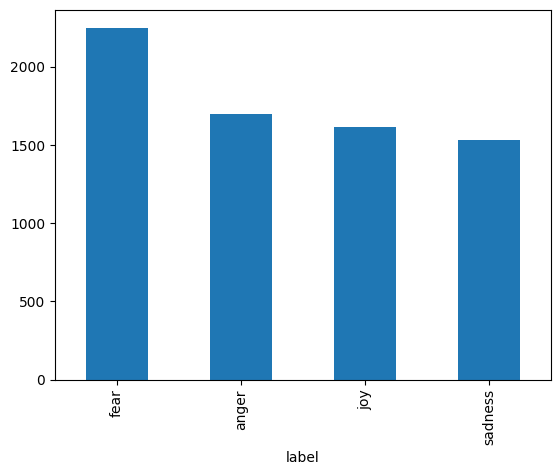

In [11]:
data['label'].value_counts().plot(kind="bar")

In [12]:
g = data.groupby('label')
data = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))

<Axes: xlabel='label'>

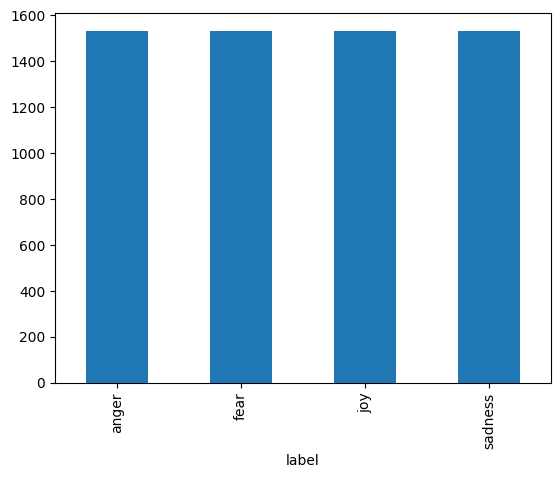

In [13]:
data['label'].value_counts().plot(kind="bar")

In [14]:
data['label_int'] = LabelEncoder().fit_transform(data['label'])

In [15]:
NUM_LABELS = 4

In [16]:
train_split, test_split = train_test_split(data, train_size = 0.8)
train_split, val_split = train_test_split(train_split, train_size = 0.9)

In [17]:
print(len(train_split))
print(len(test_split))
print(len(val_split))

4414
1227
491


In [18]:
train_df = pd.DataFrame({
    "label": train_split.label_int.values,
    "text": train_split.text_clean.values
})

test_df = pd.DataFrame({
    "label": test_split.label_int.values,
    "text": test_split.text_clean.values
})

In [19]:
train_df = datasets.Dataset.from_dict(train_df)
test_df = datasets.Dataset.from_dict(test_df)

In [20]:
dataset_dict = datasets.DatasetDict({"train":train_df, "test":test_df})

In [21]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 4414
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 1227
    })
})

## Create embeddings

In [22]:
tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")

In [23]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding = "max_length", max_length = 128, truncation=True)

In [25]:
tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)

Map: 100%|████████████████████████████████████████████████████████████████| 1227/1227 [00:00<00:00, 2139.75 examples/s]


In [26]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4414
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1227
    })
})

In [27]:
print(tokenized_datasets['train']['text'][0])

unmatched party specialist /co  #serious #job #titles


In [28]:
print(tokenized_datasets['train']['input_ids'][0])

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 31797, 489, 6273, 17, 167, 721, 17, 7967, 18968, 17, 7967, 25308, 17, 7967, 25612, 23, 4, 3]


In [29]:
tokenizer.decode(5)

'<pad>'

In [30]:
print(tokenized_datasets['train']['token_type_ids'][0])

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]


In [31]:
print(tokenized_datasets['train']['attention_mask'][0])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [32]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(100))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(100))

## Fine tune our model

In [33]:
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', 
                                                       num_labels=NUM_LABELS, 
                                                       id2label={0: 'anger', 1: 'fear', 2: 'joy', 3: 'sadness'})

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'sequence_summary.summary.bias', 'logits_proj.weight', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
metric = evaluate.load("accuracy")

In [35]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [36]:
training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch", num_train_epochs=3)

In [37]:
trainer = Trainer(
    model=model, 
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics)

In [38]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.403604,0.270000
2,No log,1.399921,0.170000
3,No log,1.397637,0.190000


TrainOutput(global_step=39, training_loss=1.3937044388208635, metrics={'train_runtime': 603.5068, 'train_samples_per_second': 0.497, 'train_steps_per_second': 0.065, 'total_flos': 21366375321600.0, 'train_loss': 1.3937044388208635, 'epoch': 3.0})

## Evaluate model

In [40]:
trainer.evaluate()

{'eval_loss': 1.3976367712020874,
 'eval_accuracy': 0.19,
 'eval_runtime': 49.9493,
 'eval_samples_per_second': 2.002,
 'eval_steps_per_second': 0.26,
 'epoch': 3.0}

In [41]:
model.save_pretrained("fine_tuned_model")

In [42]:
fine_tuned_model = XLNetForSequenceClassification.from_pretrained("fine_tuned_model")

In [43]:
clf = pipeline("text-classification", fine_tuned_model, tokenizer=tokenizer)

In [49]:
rand_int = random.randint(0, len(val_split))
print(val_split['text_clean'][rand_int])
answer = clf(val_split['text_clean'][rand_int], top_k=None)
print(answer)

come to the funeral tomorrow at 12 to mourn the death of my gpa
[{'label': 'joy', 'score': 0.2925475537776947}, {'label': 'anger', 'score': 0.2373458594083786}, {'label': 'sadness', 'score': 0.23712345957756042}, {'label': 'fear', 'score': 0.23298314213752747}]


C:\Users\lnewb\AppData\Local\Temp\ipykernel_3276\3116462782.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(val_split['text_clean'][rand_int])
C:\Users\lnewb\AppData\Local\Temp\ipykernel_3276\3116462782.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  answer = clf(val_split['text_clean'][rand_int], top_k=None)
